# pytorch_sandbox

## Initialization

In [2]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

In [3]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

In [4]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

In [5]:
# !pip install pytorch-model-summary

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport pytorch_fit
%aimport timeseries

<IPython.core.display.Javascript object>

In [27]:
import os
import IPython.display
from pprint import pprint
from datetime import datetime, timedelta
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

import timeseries as tss
from timeseries import plot_ts
from timeseries.analysis import acf, pacf, plot_hist, plot_acf, plot_pacf, plot_stats
from timeseries.transform import IHSTransformer, get_smoothed
from timeseries.forecast.utils import Results
from timeseries.forecast.utils import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from timeseries.forecast.scorings import get_comparison_scorings
from timeseries.forecast import average_scores
from timeseries.forecast.hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from timeseries.forecast.models import (
    SarimaModel,
    sarima_model_version,
    sarima_model_version_str,
)

from timeseries_pytorch import set_trainable
from timeseries_pytorch.models import TimeWindowForecastingModel
from timeseries_pytorch.transform import get_exogenous_seasonal_dct_lst
from timeseries_pytorch.datasets import TimeWindowForecastingDataset
from timeseries_pytorch.metrics import OriginalMetric


from collections import OrderedDict
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pytorch_fit
from pytorch_fit import fit, evaluate, train_epoch, evaluate
from pytorch_fit.metrics import Metric
from pytorch_fit.stopping import EarlyStopping
from pytorch_fit.visuals import (
    plot_history,
    display_last_history,
    display_network,
    format_vertical_headers,
)

from timeseries_data import WebsiteVisitsData

<IPython.core.display.Javascript object>

In [5]:
import nb_black

from notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<IPython.core.display.Javascript object>

In [6]:
ts_data = WebsiteVisitsData()
data_type = ts_data.data_type
data_name = ts_data.data_name

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

Order of differencing: 1


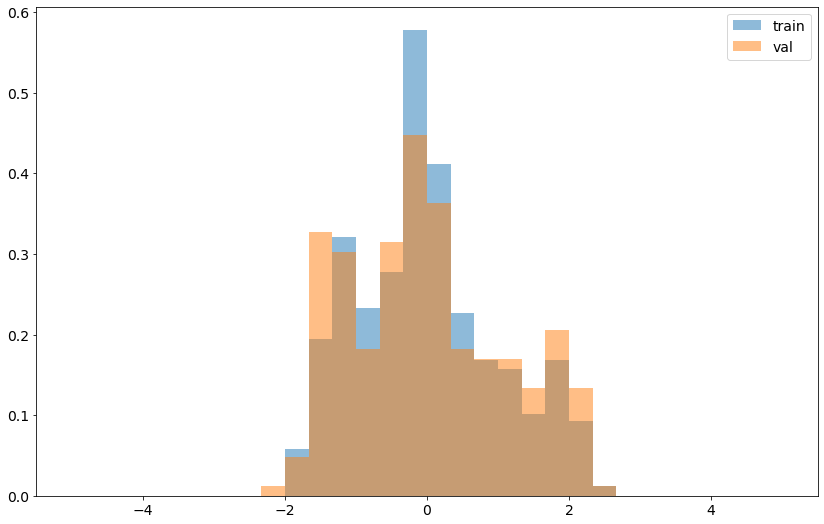

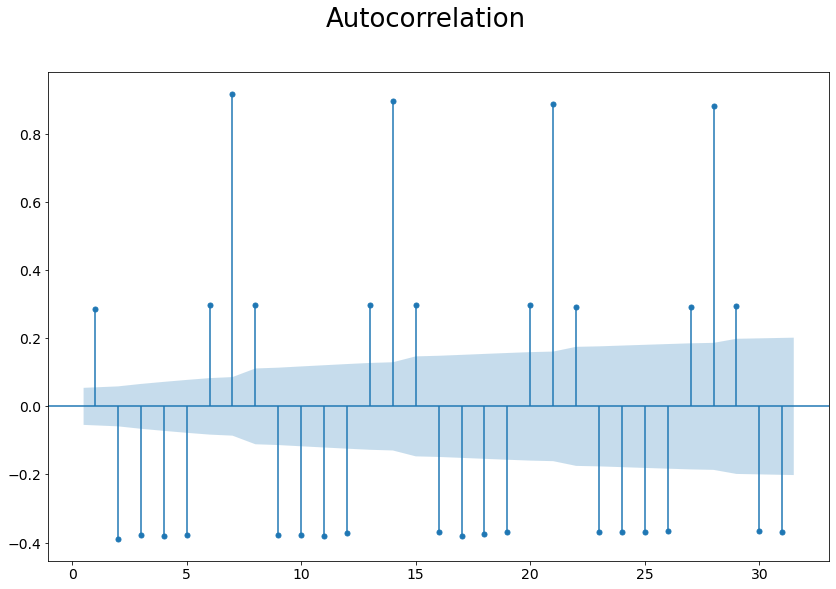

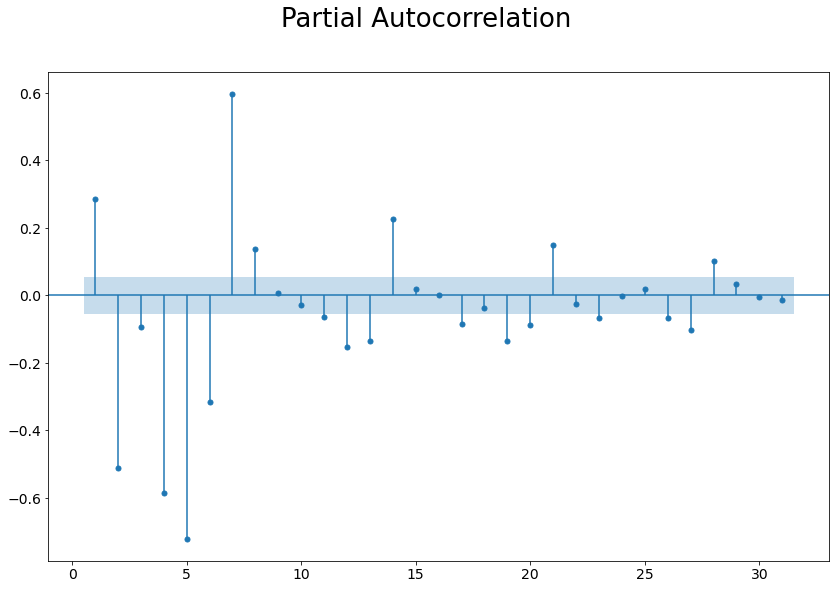

<IPython.core.display.Javascript object>

In [7]:
trans = IHSTransformer(train_intv.view(ts), lmb=None, verbose=True)
original_trans_ts = trans_ts = trans.transform(ts)

fig = plot_hist(
    train_intv.view(trans_ts), bins=30, range=(-5, 5), density=True, name="train"
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=30,
        range=(-5, 5),
        density=True,
        name="val",
        fig=fig,
        title="Distribution",
    )
)

alpha = 0.05
display(plot_acf(train_intv.view(trans_ts), alpha=alpha, zero=False))
display(plot_pacf(train_intv.view(trans_ts), alpha=alpha, zero=False))

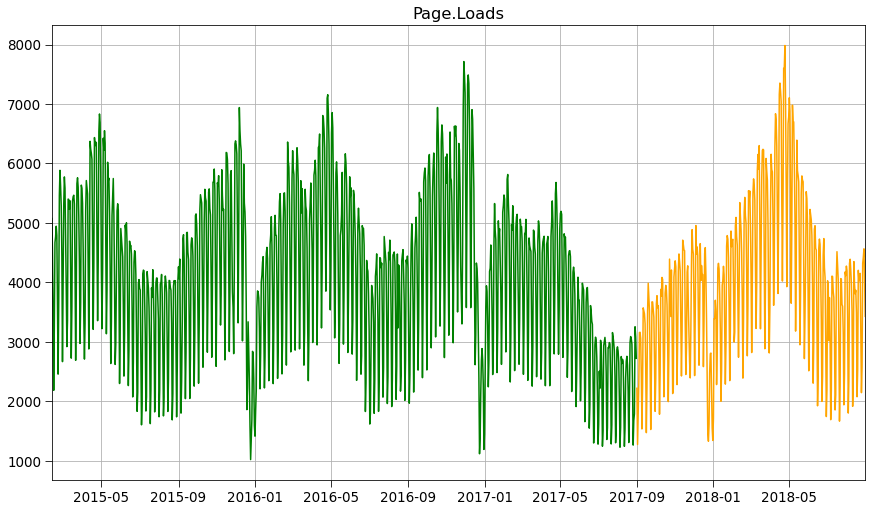

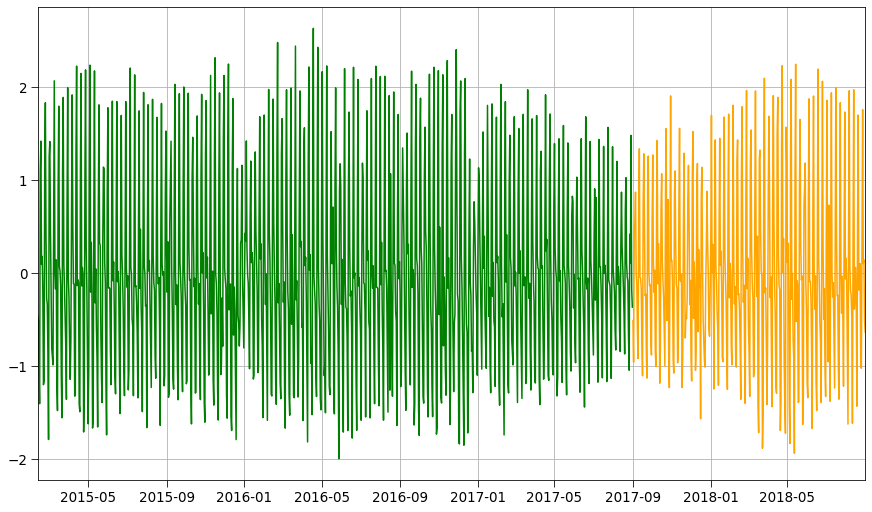

<IPython.core.display.Javascript object>

In [12]:
hyper_search_train_datetime = train_intv.begin
hyper_search_val_datetime = datetime(2017, 9, 1)
hyper_search_end_val_datetime = val_intv.begin
hyper_search_train_intv = tss.Interval(
    ts, hyper_search_train_datetime, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(
    ts, hyper_search_val_datetime, hyper_search_end_val_datetime
)
fig = plot_ts(hyper_search_train_intv.view(), color="green")
display(plot_ts(hyper_search_val_intv.view(), fig=fig, color="orange"))
fig = plot_ts(hyper_search_train_intv.view(trans_ts), color="green")
display(plot_ts(hyper_search_val_intv.view(trans_ts), fig=fig, color="orange"))

## Code

### Exogenous

In [13]:
def get_exogenous_seasonal_dct_lst(seasonal_ts_seq):
    assert type(seasonal_ts_seq) is list
    seasons_dct_lst = []
    last_i = 0
    for seasonal_ts in seasonal_ts_seq:
        seasonal_values = np.unique(seasonal_ts)
        seasons_dct = {s: last_i + i for i, s in enumerate(seasonal_values)}
        seasons_dct_lst.append(seasons_dct)
        last_i += len(seasons_dct)
    return seasons_dct_lst


def get_exogenous_seasonal_array(intv, seasonal_ts_seq):
    seasons_dct_lst = get_exogenous_seasonal_dct_lst(seasonal_ts_seq)
    return get_exogenous_seasonal_array_from_dct_lst(
        intv, seasonal_ts_seq, seasons_dct_lst
    )


def get_exogenous_seasonal_array_from_dct_lst(intv, seasonal_ts_seq, seasons_dct_lst):
    assert type(seasonal_ts_seq) is list
    m = np.sum([len(seasons_dct) for seasons_dct in seasons_dct_lst])
    n = len(intv.view(seasonal_ts_seq[0]))
    exogenous = np.zeros((m, n))
    for seasonal_ts, seasons_dct in zip(seasonal_ts_seq, seasons_dct_lst):
        s_ts = intv.view(seasonal_ts).values
        for i, s in enumerate(s_ts):
            exogenous[seasons_dct[s], i] = 1.0
    return exogenous


ex1 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
ex2 = [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5]

seasonal_ts_seq = [
    pd.Series(ex1, index=train_intv.view().index[1 : len(ex1) + 1]),
    pd.Series(ex2, index=train_intv.view().index[1 : len(ex2) + 1]),
]

intv = tss.Interval(ts, train_intv.view().index[0], train_intv.view().index[10])

seasons_dct_lst = get_exogenous_seasonal_dct_lst(seasonal_ts_seq)
exogenous = get_exogenous_seasonal_array(intv, seasonal_ts_seq)

pprint(seasons_dct_lst)
display(exogenous)


display(exogenous.shape)

[{0: 0, 1: 1}, {1: 2, 2: 3, 3: 4, 4: 5, 5: 6}]


array([[0., 1., 0., 1., 0., 1., 0., 1., 0.],
       [1., 0., 1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.]])

(7, 9)

<IPython.core.display.Javascript object>

### TimeWindowForecastingDataset

In [14]:
class TimeWindowForecastingDataset(Dataset):
    def __init__(
        self,
        ts,
        intv,
        max_window_len=None,
        window_len=None,
        pred_steps=None,
        original_ts=None,
        original_prevs_len=None,
        exogenous=None,
        seasonal_ts_seq=None,
        debug=False,
    ):
        self.debug = debug
        self.window_len = window_len
        if max_window_len is None and window_len is None:
            raise Exception("One of: max_window_len, window_len has to be provided")
        self.max_window_len = (
            max_window_len if max_window_len is not None else window_len
        )
        self.pred_steps = pred_steps
        self.y = intv.view(ts).values
        self.y = self.y.reshape((len(self.y), 1))
        self.x = intv.view(ts, prevs=self.max_window_len).values
        self.x = self.x.reshape((len(self.x), 1))
        self.exogenous = exogenous
        if seasonal_ts_seq is not None:
            assert self.exogenous is None
            assert type(seasonal_ts_seq) is list
            self.exogenous = get_exogenous_seasonal_array(intv, seasonal_ts_seq)
        if original_ts is not None:
            assert original_prevs_len is not None
            self.original_prevs_len = original_prevs_len
            self.original = intv.view(
                original_ts,
                prevs=self.original_prevs_len,
            ).values
            self.original = self.original.reshape((len(self.original), 1))
        else:
            self.original = None
        self.intv = intv

    def set(self, window_len=None, pred_steps=None):
        if window_len is not None:
            assert window_len <= self.max_window_len
            self.window_len = window_len
        if pred_steps is not None:
            self.pred_steps = pred_steps

    def __len__(self):
        if self.window_len is None:
            raise Exception(
                "window_len not provided – use self.set(window_len=) to set value"
            )
        if self.pred_steps is None:
            raise Exception(
                "pred_steps not provided – use self.set(pred_steps=) to set value"
            )
        return len(self.y) - self.pred_steps

    def __getitem__(self, idx):
        if self.window_len is None:
            raise Exception(
                "window_len not provided – use self.set(window_len=) to set value"
            )
        if self.pred_steps is None:
            raise Exception(
                "pred_steps not provided – use self.set(pred_steps=) to set value"
            )
        x = np.empty((self.x.shape[1], self.window_len), dtype=np.float32)
        x[:] = self.x[idx : idx + self.window_len, :].reshape(
            (self.x.shape[1], self.window_len)
        )
        y = np.empty((self.y.shape[1], self.pred_steps), dtype=np.float32)
        y[:] = self.y[idx : idx + self.pred_steps, :].reshape(
            (self.y.shape[1], self.pred_steps)
        )

        if self.exogenous is not None:
            ex = np.empty((self.exogenous.shape[0], self.pred_steps), dtype=np.float32)
            ex[:, :] = self.exogenous[:, idx : idx + self.pred_steps]
            xs = (x, ex)
        else:
            xs = x
        if self.original is not None:
            orignal_prevs = self.original[
                idx : idx + self.original_prevs_len, :
            ].reshape((self.original.shape[1], self.original_prevs_len))
            ys = (y, orignal_prevs)
        else:
            ys = y
        return xs, ys


days_of_week_ts = pd.Series(trans_ts.index.dayofweek, index=trans_ts.index)


train_forecasting_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=30,
    seasonal_ts_seq=[days_of_week_ts],
    original_ts=ts,
    original_prevs_len=1,
)
train_forecasting_dataset.set(window_len=10, pred_steps=5)
print(f"len: {train_forecasting_dataset.__len__()}")
train_forecasting_dataset.__getitem__(0)
train_forecasting_dataset.__getitem__(942)

len: 1293


((array([[-0.6020587 , -0.84056544,  0.2943626 ,  0.87243813,  0.28728825,
           0.08213208, -0.14727902, -0.44844425, -0.8668416 ,  0.6733457 ]],
        dtype=float32),
  array([[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0.]], dtype=float32)),
 (array([[ 0.7238768 ,  1.3383347 , -0.04520624, -0.05228059, -0.16850208]],
        dtype=float32),
  array([[1532]])))

<IPython.core.display.Javascript object>

In [15]:
ts

Date
2014-09-14    2146
2014-09-15    3621
2014-09-16    3698
2014-09-17    3667
2014-09-18    3316
              ... 
2020-08-15    2221
2020-08-16    2724
2020-08-17    3456
2020-08-18    3581
2020-08-19    2064
Name: Page.Loads, Length: 2167, dtype: int64

<IPython.core.display.Javascript object>

### SequentialForecastingDataset

In [16]:
class SequentialForecastingDataset(Dataset):
    def __init__(
        self,
        ts,
        intv,
        prefix_len,
        pred_steps=None,
        original_ts=None,
        original_prevs_len=None,
        reverse=False,
        exogenous=None,
        seasonal_ts_seq=None,
        batch_size=None,
        jump_update_steps=0,
        debug=False,
    ):
        self.prefix_len = prefix_len
        self.reverse = reverse
        self.y = intv.view(ts).values
        self.y = self.y.reshape((len(self.y), 1))
        self.x = intv.view(ts, prevs=self.prefix_len).values
        self.x = self.x.reshape((len(self.x), 1))
        self.exogenous = exogenous
        if seasonal_ts_seq is not None:
            assert self.exogenous is None
            assert type(seasonal_ts_seq) is list
            self.exogenous = get_exogenous_seasonal_array(intv, seasonal_ts_seq)
        self.pred_steps = pred_steps
        self.batch_size = batch_size
        self.jump_update_steps = jump_update_steps
        self.debug = debug
        if original_ts is not None:
            assert original_prevs_len is not None
            self.original_prevs_len = original_prevs_len
            self.original = intv.view(
                original_ts,
                prevs=self.original_prevs_len,
                #                 nexts=-self.pred_steps,
            ).values
            self.original = self.original.reshape((len(self.original), 1))
        else:
            self.original = None
        self.intv = intv

    def set(self, batch_size=None, pred_steps=None):
        if batch_size is not None:
            self.batch_size = batch_size
        if pred_steps is not None:
            self.pred_steps = pred_steps

    def __len__(self):
        if self.batch_size is None:
            raise Exception(
                "batch size not provided – use self.reset(batch_size=) to set value"
            )
        if self.pred_steps is None:
            raise Exception(
                "pred_steps not provided – use self.set(pred_steps=) to set value"
            )
        samples = len(self.x) - self.pred_steps - self.prefix_len - self.batch_size
        samples //= self.jump_update_steps + self.batch_size
        samples = (samples + 1) * self.batch_size
        return samples

    def __getitem__(self, idx):
        if self.batch_size is None:
            raise Exception(
                "batch size not provided – use self.reset(batch_size=) to set value"
            )
        if self.pred_steps is None:
            raise Exception(
                "pred_steps not provided – use self.set(pred_steps=) to set value"
            )
        if torch.is_tensor(idx):
            idx = idx.numpy()
        end = self.prefix_len + (idx // self.batch_size) * self.jump_update_steps + idx
        prev_end = end - self.batch_size - self.jump_update_steps
        if self.debug:
            print(f"idx: {idx} ({prev_end}-{end})")
        if idx < self.batch_size:
            prev_end = idx
        x = np.empty((end - prev_end, self.x.shape[1]), dtype=np.float32)
        x[:] = self.x[prev_end:end, :]
        x = x.copy()
        prev_end = end - self.prefix_len
        end = prev_end + self.pred_steps
        if self.exogenous is not None:
            ex = np.empty((self.exogenous.shape[0], self.pred_steps), dtype=np.float32)
            ex[:, :] = self.exogenous[:, prev_end:end]
            ex = np.swapaxes(ex, 0, 1)
            xs = (x, ex)
        else:
            xs = x
        y = np.empty((self.x.shape[1], self.pred_steps), dtype=np.float32)
        y[:] = self.y[
            prev_end:end,
            :,
        ].reshape(self.pred_steps)
        if self.reverse:
            y = np.flip(y, 1)
        y = y.copy()
        if self.original is not None:
            orignal_prevs = (
                self.original[
                    prev_end : prev_end + self.original_prevs_len,
                    :,
                ]
                .reshape((self.original.shape[1], self.original_prevs_len))
                .copy()
            )
            ys = (y, orignal_prevs)
        else:
            ys = y
        return xs, ys


days_of_week_ts = pd.Series(trans_ts.index.dayofweek, index=trans_ts.index)
train_forecasting_dataset = SequentialForecastingDataset(
    trans_ts,
    train_intv,
    prefix_len=10,
    pred_steps=5,
    jump_update_steps=6,
    original_ts=ts,
    original_prevs_len=1,
    seasonal_ts_seq=[days_of_week_ts],
)
train_forecasting_dataset.set(batch_size=3)


pprint(
    f"dataset.len={train_forecasting_dataset.__len__()}, train_intv.len={len(train_intv.view())}"
)
last = train_forecasting_dataset.__len__() - 1
pprint(train_forecasting_dataset.__getitem__(0))
pprint(train_forecasting_dataset.__getitem__(1))
pprint(train_forecasting_dataset.__getitem__(2))
pprint(train_forecasting_dataset.__getitem__(3))
pprint(train_forecasting_dataset.__getitem__(last))

'dataset.len=432, train_intv.len=1298'
((array([[ 0.7976522 ],
       [ 1.7638063 ],
       [ 0.14479062],
       [ 0.08213208],
       [-0.5313152 ],
       [-0.9931693 ],
       [-1.252899  ],
       [ 1.062435  ],
       [ 1.8011994 ],
       [ 0.43584964]], dtype=float32),
  array([[0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)),
 (array([[-0.45450798, -0.5070603 , -1.0103499 , -1.4014604 ,  1.0957855 ]],
      dtype=float32),
  array([[5525]])))
((array([[ 1.7638063 ],
       [ 0.14479062],
       [ 0.08213208],
       [-0.5313152 ],
       [-0.9931693 ],
       [-1.252899  ],
       [ 1.062435  ],
       [ 1.8011994 ],
       [ 0.43584964],
       [-0.45450798]], dtype=float32),
  array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1

<IPython.core.display.Javascript object>

### SequentialAutoencodingDataset

In [25]:
class SequentialAutoencodingDataset(Dataset):
    def __init__(
        self,
        ts,
        intv,
        prefix_len,
        steps_back=None,
        original_ts=None,
        original_prevs_len=None,
        one_more=False,
        teacher_forcing=False,
        input_equal_to_output=False,
        reverse=False,
        batch_size=None,
        jump_update_steps=0,
        debug=False,
    ):
        self.prefix_len = prefix_len
        self.reverse = reverse
        self.x = intv.view(ts, prevs=self.prefix_len).values
        self.x = self.x.reshape((len(self.x), 1))
        self.steps_back = steps_back
        self.batch_size = batch_size
        self.jump_update_steps = jump_update_steps
        self.debug = debug
        self.one_more = one_more
        self.teacher_forcing = teacher_forcing
        self.input_equal_to_output = input_equal_to_output
        if original_ts is not None:
            assert original_prevs_len is not None
            self.original_prevs_len = original_prevs_len
            self.original = intv.view(
                original_ts, prevs=self.original_prevs_len + 1
            ).values
            self.original = self.original.reshape((len(self.original), 1))
        else:
            self.original = None
        self.intv = intv

    def set(
        self,
        batch_size=None,
        steps_back=None,
        reverse=None,
        one_more=None,
        teacher_forcing=None,
        input_equal_to_output=None,
    ):
        if batch_size is not None:
            self.batch_size = batch_size
        if steps_back is not None:
            self.steps_back = steps_back
        if reverse is not None:
            self.reverse = reverse
        if one_more is not None:
            self.one_more = one_more
        if teacher_forcing is not None:
            self.teacher_forcing = teacher_forcing
        if input_equal_to_output is not None:
            self.input_equal_to_output = input_equal_to_output

    def __len__(self):
        if self.batch_size is None:
            raise Exception(
                "batch size not provided – use self.reset(batch_size=) to set value"
            )
        if self.steps_back is None:
            raise Exception(
                "steps_back not provided – use self.set(steps_back=) to set value"
            )
        samples = len(self.x) - self.prefix_len - self.steps_back - self.batch_size
        samples //= self.jump_update_steps + self.batch_size
        samples = (samples + 1) * self.batch_size
        return samples

    def __getitem__(self, idx):
        if self.batch_size is None:
            raise Exception(
                "batch size not provided – use self.set(batch_size=) to set value"
            )
        if self.steps_back is None:
            raise Exception(
                "steps_back not provided – use self.set(steps_back=) to set value"
            )
        if torch.is_tensor(idx):
            idx = idx.numpy()
        end = (
            self.prefix_len
            + self.steps_back
            + (idx // self.batch_size) * self.jump_update_steps
            + idx
        )
        prev_end = end - self.batch_size - self.jump_update_steps
        if self.debug:
            print(f"idx: {idx} ({prev_end}-{end})")
        if idx < self.batch_size:
            prev_end = idx
        if self.input_equal_to_output:
            prev_end = end - self.steps_back
        x = np.empty((end - prev_end, self.x.shape[1]), dtype=np.float32)
        x[:] = self.x[prev_end:end, :]
        x = x.copy()
        if self.teacher_forcing:
            tf = np.zeros((self.steps_back, self.x.shape[1]), dtype=np.float32)
            tmp = self.x[
                end - self.steps_back + 1 : end,
                :,
            ].astype(np.float32)
            if self.reverse:
                tmp = np.flip(tmp, 0).copy()
            tf[1:, :] = tmp
            xs = (x, tf)
        else:
            xs = x
        y = np.empty((self.x.shape[1], self.steps_back), dtype=np.float32)
        y[:] = self.x[
            end - self.steps_back - self.one_more : end - self.one_more,
            :,
        ].reshape(self.steps_back)
        if self.reverse:
            y = np.flip(y, 1)
        y = y.copy()
        if self.original is not None:
            pos = end - self.steps_back - self.prefix_len - self.one_more + 1
            orignal_prevs = (
                self.original[
                    pos : pos + self.original_prevs_len,
                    :,
                ]
                .reshape((self.original.shape[1], self.original_prevs_len))
                .copy()
            )
            ys = (y, orignal_prevs)
        else:
            ys = y

        return xs, ys


train_autoencoding_dataset = SequentialAutoencodingDataset(
    trans_ts,
    train_intv,
    steps_back=3,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=1,
    reverse=True,
    batch_size=10,
    jump_update_steps=1,
    one_more=False,
    teacher_forcing=True,
    input_equal_to_output=True,
)
pprint(
    f"dataset.len={train_autoencoding_dataset.__len__()}, train_intv.len={len(train_intv.view())}, "
    f"len(x)={len(train_autoencoding_dataset.x)},"
    f"len(original)={len(train_autoencoding_dataset.original)}"
)
last = train_autoencoding_dataset.__len__() - 1
pprint(train_autoencoding_dataset.__getitem__(0))
pprint(train_autoencoding_dataset.__getitem__(1))
pprint(train_autoencoding_dataset.__getitem__(2))
pprint(train_autoencoding_dataset.__getitem__(3))
pprint(train_autoencoding_dataset.__getitem__(4))
pprint(train_autoencoding_dataset.__getitem__(5))
pprint(train_autoencoding_dataset.__getitem__(6))
pprint(train_autoencoding_dataset.__getitem__(last))

'dataset.len=1170, train_intv.len=1298, len(x)=1308,len(original)=1300'
((array([[-0.45450798],
       [-0.5070603 ],
       [-1.0103499 ]], dtype=float32),
  array([[ 0.       ],
       [-1.0103499],
       [-0.5070603]], dtype=float32)),
 (array([[-1.0103499 , -0.5070603 , -0.45450798]], dtype=float32),
  array([[5525]])))
((array([[-0.5070603],
       [-1.0103499],
       [-1.4014604]], dtype=float32),
  array([[ 0.       ],
       [-1.4014604],
       [-1.0103499]], dtype=float32)),
 (array([[-1.4014604, -1.0103499, -0.5070603]], dtype=float32),
  array([[5074]])))
((array([[-1.0103499],
       [-1.4014604],
       [ 1.0957855]], dtype=float32),
  array([[ 0.       ],
       [ 1.0957855],
       [-1.4014604]], dtype=float32)),
 (array([[ 1.0957855, -1.4014604, -1.0103499]], dtype=float32),
  array([[4571]])))
((array([[-1.4014604],
       [ 1.0957855],
       [ 1.4212056]], dtype=float32),
  array([[0.       ],
       [1.4212056],
       [1.0957855]], dtype=float32)),
 (array([[ 1.

<IPython.core.display.Javascript object>

In [204]:
train_intv.view(ts, prevs=2)[:10]

Date
2015-02-09    5095
2015-02-10    5525
2015-02-11    5074
2015-02-12    4571
2015-02-13    3570
2015-02-14    2182
2015-02-15    3265
2015-02-16    4670
2015-02-17    4764
2015-02-18    4943
Name: Page.Loads, dtype: int64

<IPython.core.display.Javascript object>

In [205]:
train_intv.view(trans_ts)[:10]

Date
2015-02-11   -0.454508
2015-02-12   -0.507060
2015-02-13   -1.010350
2015-02-14   -1.401460
2015-02-15    1.095786
2015-02-16    1.421206
2015-02-17    0.096281
2015-02-18    0.182184
2015-02-19   -0.153343
2015-02-20   -1.197315
dtype: float64

<IPython.core.display.Javascript object>

### StatefulModule

In [24]:
class StatefulModule(nn.Module):
    def __init__(self, debug=False, **kwargs):
        super().__init__()
        self.debug = debug
        self.reset(batch_size=None)

    def stateful_submodules(self):
        return [
            module
            for module in self.children()
            if issubclass(type(module), StatefulModule)
        ]

    def set(self, **kwargs):
        if "debug" in kwargs:
            self.debug = kwargs["debug"]

        self.__set__(**kwargs)
        for module in self.stateful_submodules():
            module.set(**kwargs)

        if "batch_size" in kwargs:
            self.reset(batch_size=kwargs["batch_size"])

    def reset(self, **kwargs):
        if self.debug:
            print(f"self.reset {self.__class__}({self.__hash__()})")
        if "batch_size" in kwargs:
            self.batch_size = kwargs["batch_size"]
        self.__reset__(**kwargs)
        for module in self.stateful_submodules():
            if self.debug:
                print(
                    f"children of {self.__hash__()}: {module.__class__}({module.__hash__()})"
                )
            module.reset(**kwargs)

    def forward(self, x, *args, **kwargs):
        if self.batch_size != x.size(0):
            self.reset(batch_size=x.size(0))
        return self.__forward__(x, *args, **kwargs)

    @abstractmethod
    def __set__(self, **kwargs):
        pass

    @abstractmethod
    def __reset__(self, **kwargs):
        pass

    @abstractmethod
    def __forward__(self, x, *args):
        pass

<IPython.core.display.Javascript object>

### StatefulLSTM

In [26]:
class SatefulLSTM(StatefulModule):
    def __init__(self, input_size, hidden_size, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.num_layers = 1
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=self.dropout,
            batch_first=True,
        )
        self.hidden_state = None
        self.cell_state = None

    def set_hidden_state(self, hidden_state):
        self.reset(batch_size=hidden_state.size(1))
        if self.debug:
            print(f"{hidden_state.shape} == (self) {self.hidden_state.shape}")
        assert hidden_state.shape == self.hidden_state.shape
        self.hidden_state = hidden_state

    def set_cell_state(self, cell_state):
        if self.batch_size is None:
            self.reset(batch_size=cell_state.size(1))
        assert cell_state.shape == self.cell_state.shape
        self.cell_state = cell_state

    def __reset__(self, **kwargs):
        if self.debug:
            print(f"LSTM.__reset__(): batch_size {self.batch_size}")
        if "batch_size" in kwargs:
            self.batch_size = kwargs["batch_size"]
        if self.batch_size is None:
            self.hidden_state = None
            self.cell_state = None
        else:
            self.hidden_state = torch.zeros(
                self.num_layers, self.batch_size, self.hidden_size
            ).to(device)
            self.cell_state = torch.zeros(
                self.num_layers, self.batch_size, self.hidden_size
            ).to(device)
            if self.debug:
                print(f"LSTM self.hidden_state.shape {self.hidden_state.shape}")

    def __forward__(self, x):
        h_0 = Variable(self.hidden_state)
        c_0 = Variable(self.cell_state)
        if self.debug:
            print(x.shape)
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        self.hidden_state = h_n
        self.cell_state = c_n
        return out, (h_n, c_n)


#     def train(self, x, y, epochs=10, lr=None, optim=None, loss=None):
# #         criterion = torch.nn.MSELoss()
#         optimizer = torch.optim.Adam(lstm.parameters(), lr=lr)

#         for epoch in range(epochs):
#             outputs = self.forward(x)  # forward pass
#             optimizer.zero_grad()  # caluclate the gradient, manually setting to 0

#             # obtain the loss function
#             loss = loss(outputs, y)

#             loss.backward()  # calculates the loss of the loss function

#             optimizer.step()  # improve from loss, i.e backprop
#             if epoch % 10 == 0 or epoch + 1 == epochs:
#                 print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))


(x, ex), y = train_forecasting_dataset.__getitem__(0)
x = torch.tensor(x).reshape((1, x.shape[0], x.shape[1])).to(device)
print(f"x.shape: {x.shape}")

model = SatefulLSTM(input_size=1, hidden_size=6, debug=False).to(device)

out, (hn, cn) = model(x)
print(f"out.shape: {out.shape}")
print(f"hn.shape: {hn.shape}")
print(f"cn.shape: {cn.shape}")

x.shape: torch.Size([1, 10, 1])
out.shape: torch.Size([1, 10, 6])
hn.shape: torch.Size([1, 1, 6])
cn.shape: torch.Size([1, 1, 6])


<IPython.core.display.Javascript object>

### StackedStatefulLSTMs

In [27]:
class StackedStatefulLSTMs(StatefulModule):
    def __init__(self, input_size, hidden_sizes, dropout=0.0, dropouts=None, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        if dropouts is None:
            self.dropouts = [dropout for _ in range(len(hidden_sizes))] + [0.0]
        else:
            self.dropouts = dropouts
        self.lstms = nn.ModuleList(
            [
                SatefulLSTM(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    dropout=dropout,
                    **kwargs,
                )
                for input_size, hidden_size, dropout in zip(
                    [self.input_size] + self.hidden_sizes,
                    self.hidden_sizes,
                    self.dropouts,
                )
            ]
        )
        self.reset()

    def __forward__(self, x):
        hs = []
        cs = []
        for lstm in self.lstms:
            out, (h_n, c_n) = lstm(x)
            hs.append(h_n)
            cs.append(c_n)
            x = out
        return out, (hs, cs)


(x, ex), y = train_forecasting_dataset.__getitem__(0)
x = torch.tensor(x).reshape((1, x.shape[0], x.shape[1])).to(device)

stacked_lstms = StackedStatefulLSTMs(input_size=1, hidden_sizes=[4, 8]).to(device)

out, (hs, cs) = stacked_lstms(x)
print(f"out.shape: {out.shape}")
print(f"hn.shapes: {[hn.shape for hn in hs]}")
print(f"cn.shapes: {[cn.shape for cn in cs]}")

out.shape: torch.Size([1, 10, 8])
hn.shapes: [torch.Size([1, 1, 4]), torch.Size([1, 1, 8])]
cn.shapes: [torch.Size([1, 1, 4]), torch.Size([1, 1, 8])]


<IPython.core.display.Javascript object>

### Losses and Metrics

In [52]:
class OriginalMetric(Metric):
    def __init__(self, trans, scoring_name, reverse_output=False):
        super().__init__()
        self.trans = trans
        self.scoring_name = scoring_name
        self.scoring = get_scoring(scoring_name)
        self.reverse_output = reverse_output
        self.steps = None
        self.reset_state()

    def reset_state(self):
        self.sum_of_errors = 0
        self.all_samples = 0

    def set_steps(steps):
        self.steps = steps

    def update_state(self, y_pred, y_true, original_prevs, *args):
        y_pred = y_pred.cpu().detach().numpy()
        y_true = y_true.cpu().detach().numpy()
        if self.reverse_output:
            y_pred = np.flip(y_pred, 2)
        if self.steps is not None:
            y_pred = y_pred[:, :, : self.steps]
            y_true = y_true[:, :, : self.steps]
        #             print(f"y_pred.shape: {y_pred.shape}, y_true.shape: {y_true.shape}")
        original_prevs = original_prevs.numpy()
        n = len(y_pred)
        for i in range(n):
            pred = y_pred[i]
            true = y_true[i]
            prevs = original_prevs[i]
            m = len(pred)
            s = 0
            for j in range(m):
                original_pred = self.trans.detransform(pred[j], prevs[j])
                original_true = self.trans.detransform(true[j], prevs[j])
                s += self.scoring(original_true, original_pred)
            self.sum_of_errors += s / m
        self.all_samples += n

    def value(self):
        return self.sum_of_errors / self.all_samples

    def is_value_simple(self):
        return True

    def name(self):
        return self.scoring_name

    def short_name(self):
        return self.scoring_name

<IPython.core.display.Javascript object>

In [53]:
class StepsLoss:
    def __init__(self, loss):
        self.steps = None
        self.loss = loss

    def set_steps(self, steps):
        self.steps = steps

    def __call__(self, y_pred, y_true):
        if self.steps is not None:
            y_pred = y_pred[:, :, : self.steps]
            y_true = y_true[:, :, : self.steps]
        #             print(f"y_pred.shape: {y_pred.shape}, y_true.shape: {y_true.shape}")
        return self.loss(y_pred, y_true)

<IPython.core.display.Javascript object>

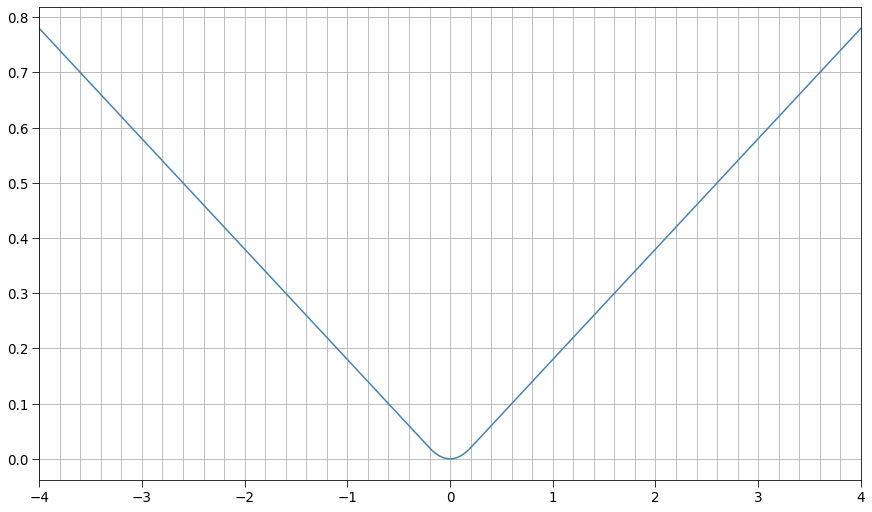

<IPython.core.display.Javascript object>

In [32]:
huber_loss = torch.nn.HuberLoss(
    reduction="mean",
    delta=0.2,
)
a = np.linspace(-4, 4, 200)
tmp = []
for i in range(0, 200):
    tmp.append(huber_loss(torch.tensor([0.0]), torch.tensor(a[i : i + 1])))
tmp = pd.Series(tmp, index=a)
plot_ts(tmp)

In [49]:
import matplotlib.colors as mcolors

<IPython.core.display.Javascript object>

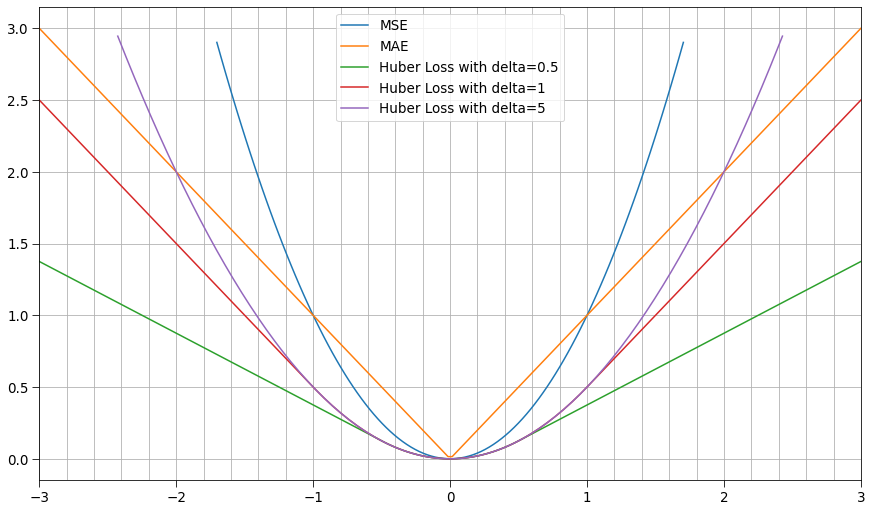

<IPython.core.display.Javascript object>

In [75]:
deltas = [0.5, 1, 5]
names = []
losses = []
names.append("MSE")
losses.append(
    torch.nn.MSELoss(
        reduction="mean",
    )
)
names.append("MAE")
losses.append(
    torch.nn.L1Loss(
        reduction="mean",
    )
)
names += [f"Huber Loss with delta={delta}" for delta in deltas]
losses += [
    torch.nn.HuberLoss(
        reduction="mean",
        delta=delta,
    )
    for delta in deltas
]
idx = range(0, 200)
a = np.linspace(-3, 3, 200)
fig = None
kwargs = dict(engine="pyplot")
for loss, name, color in zip(losses, names, mcolors.TABLEAU_COLORS):
    series = pd.Series(
        data=[loss(torch.tensor([0.0]), torch.tensor(a[i : i + 1])) for i in idx],
        index=a,
    )
    series = series[series <= 3]
    fig = plot_ts(
        series,
        name=name,
        color=color,
        **kwargs,
    )
    kwargs["fig"] = fig
display(fig)

### TimeWindowForecastingModel

In [29]:
class TimeWindowForecastingModel(Model):
    def __init__(self, module, window_len, device, detrans=None, seasons_dct_lst=None):
        super().__init__()
        self.module = module
        self.window_len = window_len
        self.device = device
        self.detrans = detrans
        self.seasons_dct_lst = seasons_dct_lst

    def fit(self, *args, **kwargs):
        pass

    def update(self, *args, **kwargs):
        pass

    def predict(self, ts, pred_interval, original_ts=None, seasonal_ts_seq=None):
        target_index = pred_interval.index()
        pred_steps = len(target_index)
        assert len(pred_interval.index(ts)) == pred_steps

        x = pred_interval.view(ts, prevs=self.window_len, nexts=-pred_steps).values
        x = x.reshape(1, 1, self.window_len).astype(np.float32)
        x = torch.tensor(x).to(self.device)

        if seasonal_ts_seq is not None:
            assert self.seasons_dct_lst is not None
            assert type(seasonal_ts_seq) is list
            ex = get_exogenous_seasonal_array_from_dct_lst(
                pred_interval, seasonal_ts_seq, self.seasons_dct_lst
            )
            ex = ex.astype(np.float32)
            ex = torch.tensor(ex).reshape(1, ex.shape[0], pred_steps).to(self.device)
        else:
            ex = None
        pred_values = self.module(x, ex).cpu().detach().numpy().reshape(pred_steps)
        pred = pd.Series(pred_values, target_index, name=pred_interval.ts.name)
        if self.detrans is not None:
            assert original_ts is not None
            pred = self.detrans.detransform(pred, pred_interval.prev_view(original_ts))
        pred.name = pred_interval.ts.name
        return pred

<IPython.core.display.Javascript object>

### SequentialForecastingModel

In [30]:
class SequentialForecastingModel(Model):
    def __init__(self, module, device, detrans=None, seasons_dct_lst=None):
        super().__init__()
        self.module = module
        self.device = device
        self.detrans = detrans
        self.seasons_dct_lst = seasons_dct_lst

    def fit(self, ts, train_interval, *args, **kwargs):
        self.ts = train_interval.view(ts)

    def update(self, ts, new_interval, **kwargs):
        new_interval = self.__update_ts__(ts, new_interval)
        if new_interval is not None:
            x = new_interval.view(self.ts).values
            x = x.reshape(1, len(x), 1).astype(np.float32)
            x = torch.tensor(x).to(self.device)
            h = self.module.encoder(x)
            self.module.decoder.set_hidden_state(h)

    def predict(self, ts, pred_interval, original_ts=None, seasonal_ts_seq=None):
        target_index = pred_interval.index()
        pred_steps = len(target_index)
        assert len(pred_interval.index(ts)) == pred_steps

        y0 = torch.tensor(
            np.array(self.ts[-1]).reshape((1, 1, 1)).astype(np.float32)
        ).to(self.device)
        x = y0[:, 0:0, :]

        if seasonal_ts_seq is not None:
            assert self.seasons_dct_lst is not None
            assert type(seasonal_ts_seq) is list
            ex = get_exogenous_seasonal_array_from_dct_lst(
                pred_interval, seasonal_ts_seq, self.seasons_dct_lst
            )
            ex = np.swapaxes(ex, 0, 1)
            ex = ex.astype(np.float32)
            ex = torch.tensor(ex).reshape(1, ex.shape[0], ex.shape[1]).to(self.device)
        else:
            ex = None
        pred_values = (
            self.module(x=x, ex=ex, y=y0).cpu().detach().numpy().reshape(pred_steps)
        )
        pred = pd.Series(pred_values, target_index, name=pred_interval.ts.name)
        if self.detrans is not None:
            assert original_ts is not None
            pred = self.detrans.detransform(pred, pred_interval.prev_view(original_ts))
        pred.name = pred_interval.ts.name
        return pred

<IPython.core.display.Javascript object>

## LSTM autoencoding

In [55]:
class StatefulLSTMsEncoder(StatefulModule):
    def __init__(self, input_size, hidden_sizes, **kwargs):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.stacked_lstms = StackedStatefulLSTMs(
            input_size=self.input_size, hidden_sizes=self.hidden_sizes, **kwargs
        )

    def __forward__(self, x):
        if x.size(1) > 0:
            out, (hs, cs) = self.stacked_lstms(x)
            h = hs[-1]
        else:
            h = self.stacked_lstms.lstms[-1].hidden_state
        return h


class StatefulLSTMsDecoder(StatefulModule):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        recursive_input=False,
        output_len=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.stacked_lstms = StackedStatefulLSTMs(
            input_size=self.input_size, hidden_sizes=self.hidden_sizes, **kwargs
        )
        self.tdd = nn.Conv2d(1, self.output_size, (1, self.hidden_sizes[-1]))
        self.set(recursive_input=recursive_input, output_len=output_len)

    def set_hidden_state(self, hidden_state):
        self.reset(batch_size=hidden_state.size(1))
        self.stacked_lstms.lstms[0].set_hidden_state(hidden_state)

    def __set__(self, **kwargs):
        if "recursive_input" in kwargs:
            self.recursive_input = kwargs["recursive_input"]
        if "output_len" in kwargs:
            self.output_len = kwargs["output_len"]

    def __forward__(self, x, h=None, ex=None):
        self.reset()
        self.stacked_lstms.lstms[0].set_hidden_state(h)

        device = x.get_device()

        if self.recursive_input:
            x0 = x[:, 0:1, :]
            x = torch.zeros((x0.size(0), self.output_len, self.output_size)).to(device)
            for i in range(self.output_len):
                x0 = x0.reshape((x0.size(0), 1, x0.size(2)))
                #                 print(f"x0.shape: {x0.shape}")
                if ex is not None:
                    #                     print(f"ex[:, i : i + 1, :].shape: {ex[:, i : i + 1, :].shape}")
                    x0 = torch.cat((x0, ex[:, i : i + 1, :]), 2)
                #                     print(f"x0 + ex.shape: {x0.shape}")
                #                 print(self.stacked_lstms)
                out, _ = self.stacked_lstms(x0)
                #                 print(f"out.shape {out.shape}")
                out = out.reshape((out.size(0), 1, out.size(1), out.size(2)))
                #                 print(f"out.shape {out.shape}")
                x0 = self.tdd(out)
                #                 print(f"x0.shape {x0.shape}")
                x0 = x0.reshape((x0.size(0), 1, self.output_size))
                #                 print(f"x0.shape {x0.shape}")
                x[:, i : i + 1, :] = x0
        else:
            if x.size(1) != self.output_len:
                x = torch.zeros((x.size(0), self.output_len, self.input_size)).to(
                    device
                )
            if ex is not None:
                input_size += ex.size(2)
                x = torch.cat((x, ex), 1)
            out, (hs, cs) = self.stacked_lstms(x)
            out = out[:, : self.output_len, :]
            #             print(f"out.shape {out.shape}")
            out = out.reshape((out.size(0), 1, out.size(1), out.size(2)))
            #             print(f"out.shape {out.shape}")
            x = self.tdd(out)
        #             print(f"out.shape {x.shape}")

        #         x = x.reshape((x.size(0), x.size(2), x.size(1)))

        x = x.reshape((x.size(0), self.output_size, self.output_len))
        return x


encoder = StatefulLSTMsEncoder(input_size=1, hidden_sizes=[16, 8, 4]).to(device)
decoder = StatefulLSTMsDecoder(input_size=1, output_size=1, hidden_sizes=[4, 8]).to(
    device
)
decoder.set(output_len=2)
decoder.set(recursive_input=True)

n = 5
train_autoencoding_dataset.set(batch_size=5, steps_back=2)
xs = torch.tensor(
    np.array(
        [
            x
            for (x, y), _ in (
                train_autoencoding_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"xs.shape: {xs.shape}")
ys = torch.tensor(
    np.array(
        [
            y
            for (x, y), _ in (
                train_autoencoding_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"ys.shape: {ys.shape}")
true_ys = torch.tensor(
    np.array(
        [
            y
            for _, (y, _) in (
                train_autoencoding_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"true_ys.shape: {true_ys.shape}")

encoded = encoder(xs)
print(f"encoded.shape: {encoded.shape}")

zeros = torch.zeros(xs.shape).to(device)

# decoder.set(output_len=ys[0].shape[1])
decoded = decoder(x=zeros, h=encoded)
print(f"decoded.shape: {decoded.shape}")

xs.shape: torch.Size([5, 2, 1])
ys.shape: torch.Size([5, 2, 1])
true_ys.shape: torch.Size([5, 1, 2])
encoded.shape: torch.Size([1, 5, 4])
decoded.shape: torch.Size([5, 1, 2])


<IPython.core.display.Javascript object>

In [56]:
class StatefulLSTMsAutoencoder(StatefulModule):
    def __init__(self, encoder, decoder, zero_input_to_decoder=False, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.zero_input_to_decoder = zero_input_to_decoder

    def __set__(self, **kwargs):
        if "output_len" in kwargs:
            self.output_len = kwargs["output_len"]

    def __forward__(self, x, y=None):
        assert self.output_len is not None
        device = x.get_device()
        self.decoder.set(output_len=self.output_len)
        encoded_h = self.encoder(x)
        if y is None:
            if self.zero_input_to_decoder:
                y = torch.zeros((x.size(0), self.output_len, x.size(2))).to(device)
            else:
                if x.size(1) >= 2:
                    y = x[:, -2:-1, :]
                else:
                    raise Exception(
                        "x.size(1) has to be at least 2 or y has to be provided"
                    )
        decoded = self.decoder(x=y, h=encoded_h)
        return decoded


autoencoder = StatefulLSTMsAutoencoder(encoder, decoder)
autoencoder.set(output_len=2)
autoencoder(xs)

tensor([[[0.0704, 0.0744]],

        [[0.0708, 0.0748]],

        [[0.0739, 0.0775]],

        [[0.0753, 0.0788]],

        [[0.0522, 0.0579]]], device='cuda:0', grad_fn=<ViewBackward>)

<IPython.core.display.Javascript object>

In [49]:
def random_steps(max_steps):
    return max(1, max_steps - abs(int(np.random.normal(0, max_steps / 2, 1)[0])))

<IPython.core.display.Javascript object>

In [48]:
train_aenc_dataset = SequentialAutoencodingDataset(
    trans_ts,
    train_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
)

val_aenc_dataset = SequentialAutoencodingDataset(
    trans_ts,
    val_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
    jump_update_steps=50,
)

<IPython.core.display.Javascript object>

### fit

In [57]:
val_batch_size = 10
reverse = True
recursive_input = True
teacher_forcing = False

encoder = StatefulLSTMsEncoder(
    input_size=1, hidden_sizes=[32, 16, 8], dropouts=[0.2, 0.2, 0]
).to(device)
decoder = StatefulLSTMsDecoder(
    input_size=1,
    output_size=1,
    hidden_sizes=[8, 16],
    recursive_input=recursive_input,
    #     dropouts=[0, 0, 0.5, 0.5, 0.5, 0],
).to(device)
autoencoder = StatefulLSTMsAutoencoder(encoder, decoder).to(device)

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=20, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "mae", "val_mae", n_epochs=30, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)


huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.1)
mse_loss = torch.nn.MSELoss(reduction="sum")
steps_loss = StepsLoss(mse_loss)
original_mae = OriginalMetric(trans, "mae", reverse_output=reverse)

history_lst = []
initial_epoch = 1
for max_steps_back in range(1, 15):
    batch_size = 100
    train_aenc_dataset.set(
        steps_back=max_steps_back,
        batch_size=batch_size,
        teacher_forcing=teacher_forcing,
    )
    aenc_train_loader = DataLoader(train_aenc_dataset, batch_size=batch_size)
    val_aenc_dataset.set(
        steps_back=max_steps_back,
        batch_size=val_batch_size,
        teacher_forcing=teacher_forcing,
    )
    aenc_val_loader = DataLoader(val_aenc_dataset, batch_size=val_batch_size)

    autoencoder.set(output_len=max_steps_back)

    def callback_before_train_batch():
        steps_back = random_steps(max_steps_back)
        steps_loss.set_steps(steps_back)

    def callback_after_train_batch():
        steps_loss.set_steps(None)

    print(f"\nmax_steps_back: {max_steps_back}")

    history = {}
    history_lst.append(history)
    fit(
        autoencoder,
        device,
        "SGD",
        steps_loss,
        aenc_train_loader,
        aenc_val_loader,
        metrics=[original_mae],
        metrics_val_only=True,
        precision=4,
        lr=1e-1,
        initial_epoch=initial_epoch,
        n_epochs=10000,
        reset=True,
        #         reset_after_train_batch=True,
        callback_before_train_batch=callback_before_train_batch,
        callback_after_train_batch=callback_after_train_batch,
        stop_cond=val_stopping,
        history=history,
    )
    initial_epoch = len(history["Loss"]["train_loss"]) + 1
plot_history(history)


max_steps_back: 1
Epoch   10:   train_loss: 1.0024, val_loss: 0.9996, val_mae: 812, elapsed time: 3.6s lapsed time: 3.6s 
Epoch   20:   train_loss: 1.0013, val_loss: 0.9977, val_mae: 812, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   30:   train_loss: 0.9994, val_loss: 0.9946, val_mae: 811, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   40:   train_loss: 0.9950, val_loss: 0.9876, val_mae: 810, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   50:   train_loss: 0.9815, val_loss: 0.9680, val_mae: 804, elapsed time: 3.1s lapsed time: 3.1s 
Epoch   60:   train_loss: 0.9256, val_loss: 0.9044, val_mae: 792, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   70:   train_loss: 0.8007, val_loss: 0.8028, val_mae: 745, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   80:   train_loss: 0.7402, val_loss: 0.7480, val_mae: 705, elapsed time: 3.2s lapsed time: 3.2s 
Epoch   90:   train_loss: 0.6968, val_loss: 0.7257, val_mae: 681, elapsed time: 3.2s lapsed time: 3.2s 
Epoch  100:   train_loss: 0.6479, val_loss: 0

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

[ 0.30938855 -0.272245   -0.42619878 -0.33126134 -0.24375468]
[ 0.         1.0957855 -1.4014604 -1.0103499 -0.5070603]


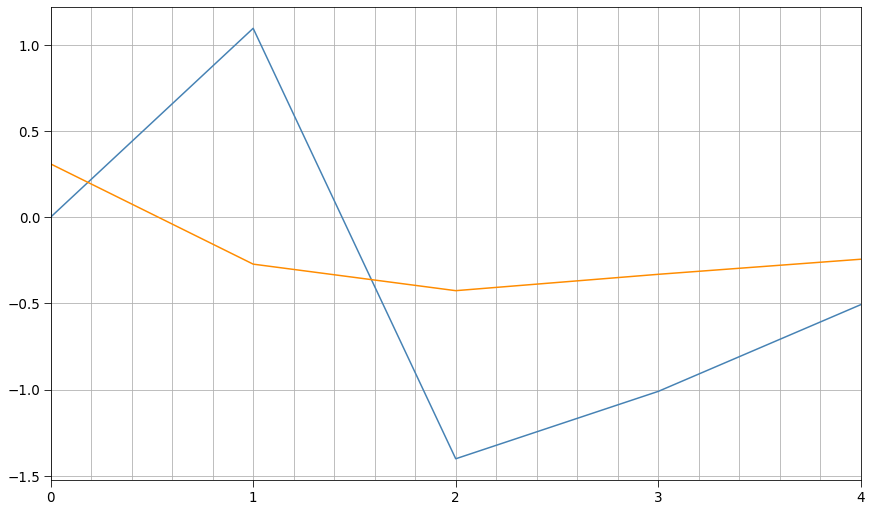

<IPython.core.display.Javascript object>

In [58]:
steps_back = 5
train_autoencoding_dataset.set(steps_back=steps_back)
(x, y), (true_y, original_prevs) = train_autoencoding_dataset.__getitem__(0)
true_y = y.reshape(steps_back)
x = x.reshape((1, x.shape[0], x.shape[1]))
x = torch.tensor(x).to(device)
y = y.reshape((1, y.shape[0], y.shape[1]))
y = torch.tensor(y).to(device)
autoencoder.set(output_len=steps_back)
out = autoencoder(x, y=y).cpu().detach().numpy().reshape(steps_back)
print(out)
print(true_y)
fig = plot_ts(true_y)
plot_ts(out, color="darkorange", fig=fig)
display(fig)

In [88]:
torch.save(encoder.state_dict(), "encoder1.pth")

<IPython.core.display.Javascript object>

## LSTM forecasting

In [223]:
def set_trainable(module, trainable=True):
    for param in module.parameters():
        param.requires_grad = trainable

<IPython.core.display.Javascript object>

In [412]:
class StatefulLSTMsForecaster(StatefulModule):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def __set__(self, **kwargs):
        if "output_len" in kwargs:
            self.output_len = kwargs["output_len"]

    def __forward__(self, x, ex=None, y=None):
        assert self.output_len is not None
        self.decoder.set(output_len=self.output_len)
        encoded_h = self.encoder(x)
        if y is not None and y.size(1) > 0:
            y0 = y[:, 0:1, :]
        else:
            if x.size(1) > 0:
                y0 = x[:, -1:, :]
            else:
                raise Exception("One of x or y has to greater than zero in length.")
        out = self.decoder(x=y0, h=encoded_h, ex=ex)
        return out

<IPython.core.display.Javascript object>

In [400]:
train_fc_dataset = SequentialForecastingDataset(
    trans_ts,
    train_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
)

val_fc_dataset = SequentialForecastingDataset(
    trans_ts,
    val_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
    jump_update_steps=50,
)

<IPython.core.display.Javascript object>

In [437]:
forecasting_encoder = StatefulLSTMsEncoder(
    input_size=1, hidden_sizes=[32, 16, 8], dropout=0.25
)
forecasting_encoder.load_state_dict(torch.load("encoder1.pth"))
forecasting_encoder = forecasting_encoder.to(device)
set_trainable(forecasting_encoder, False)
forecasting_encoder.eval()

forecasting_decoder = StatefulLSTMsDecoder(
    input_size=1,
    hidden_sizes=[8, 16, 32, 1],
    recursive_input=recursive_input,
    #     dropout=0.05,
).to(device)

forecaster = StatefulLSTMsForecaster(forecasting_encoder, forecasting_decoder).to(
    device
)

n = 5

pred_steps = 4
train_fc_dataset.set(pred_steps=pred_steps, batch_size=4)
forecasting_decoder.set(output_len=pred_steps)

n = 5
train_fc_dataset.set(batch_size=n)
xs = torch.tensor(
    np.array(
        [x for x, _ in (train_fc_dataset.__getitem__(i) for i in range(0, n))],
        dtype=np.float32,
    )
).to(device)
print(f"xs.shape: {xs.shape}")

y0 = xs[:, -1:, :]
# x = xs[:, 0:0, :]
x = xs
print(f"y0.shape: {y0.shape}")
print(f"x.shape: {x.shape}")

encoded = forecasting_encoder(xs)
print(f"encoded.shape: {encoded.shape}")

zeros = torch.zeros(x.shape).to(device)

decoded = forecasting_decoder(x=y0, h=encoded)
print(f"decoded.shape: {decoded.shape}")

forecaster.set(output_len=4)
forecaster(x, y=y0)
forecaster(x)

xs.shape: torch.Size([5, 10, 1])
y0.shape: torch.Size([5, 1, 1])
x.shape: torch.Size([5, 10, 1])
encoded.shape: torch.Size([1, 5, 8])
decoded.shape: torch.Size([5, 1, 4])


tensor([[[-0.0196, -0.0192, -0.0191, -0.0191]],

        [[-0.0196, -0.0193, -0.0191, -0.0192]],

        [[-0.0195, -0.0192, -0.0191, -0.0192]],

        [[-0.0194, -0.0191, -0.0190, -0.0190]],

        [[-0.0192, -0.0189, -0.0188, -0.0189]]], device='cuda:0',
       grad_fn=<ViewBackward>)

<IPython.core.display.Javascript object>

In [438]:
forecasting_encoder = StatefulLSTMsEncoder(
    input_size=1, hidden_sizes=[32, 16, 8], dropout=0
)
forecasting_encoder.load_state_dict(torch.load("encoder1.pth"))
forecasting_encoder = forecasting_encoder.to(device)
set_trainable(forecasting_encoder, False)
forecasting_encoder.eval()

forecasting_decoder = StatefulLSTMsDecoder(
    input_size=1,
    hidden_sizes=[8, 8, 1],
    recursive_input=recursive_input,
    #     dropout=0.05,
).to(device)

forecaster = StatefulLSTMsForecaster(forecasting_encoder, forecasting_decoder).to(
    device
)

set_trainable(forecasting_encoder, False)

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=20, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "mae", "val_mae", n_epochs=20, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)


huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.5)
steps_loss = StepsLoss(huber_loss)
original_mae = OriginalMetric(trans, "mae", reverse_output=reverse)

history = {}
initial_epoch = 1
for max_pred_steps in range(1, 7):
    batch_size = 100
    train_fc_dataset.set(pred_steps=max_pred_steps, batch_size=batch_size)
    fc_train_loader = DataLoader(train_fc_dataset, batch_size=batch_size)
    val_fc_dataset.set(pred_steps=max_pred_steps, batch_size=val_batch_size)
    fc_val_loader = DataLoader(val_fc_dataset, batch_size=val_batch_size)

    forecaster.set(output_len=max_pred_steps)

    def callback_before_train_batch():
        pred_steps = random_steps(max_pred_steps)
        steps_loss.set_steps(pred_steps)

    def callback_after_train_batch():
        steps_loss.set_steps(None)

    print(f"\nmax_pred_steps: {max_pred_steps}")

    fit(
        forecaster,
        device,
        "Adam",
        steps_loss,
        fc_train_loader,
        fc_val_loader,
        metrics=[original_mae],
        metrics_val_only=True,
        precision=4,
        lr=1e-3,
        initial_epoch=initial_epoch,
        n_epochs=10000,
        reset=True,
        reset_after_train_batch=True,
        callback_before_train_batch=callback_before_train_batch,
        callback_after_train_batch=callback_after_train_batch,
        stop_cond=val_stopping,
        history=history,
    )
    initial_epoch = len(history["Loss"]["train_loss"]) + 1
plot_history(history)


max_pred_steps: 1
Epoch   10:   train_loss: 0.2914, val_loss: 0.3010, val_mae: 801, elapsed time: 3.8s lapsed time: 3.8s 
Epoch   11:   Training: [=============1100/1200(91%)==========>    ]  loss: 0.2858, elapsed time: 0.2s 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### Seasonal

In [403]:
days_of_week_ts = pd.Series(trans_ts.index.dayofweek, index=trans_ts.index)
days_of_week_dct = get_exogenous_seasonal_dct_lst([days_of_week_ts])
days_of_week = len(days_of_week_dct[0])

train_seasonal_fc_dataset = SequentialForecastingDataset(
    trans_ts,
    train_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
)

val_seasonal_fc_dataset = SequentialForecastingDataset(
    trans_ts,
    val_intv,
    prefix_len=10,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
    jump_update_steps=50,
)

<IPython.core.display.Javascript object>

In [435]:
seasonal_forecasting_encoder = StatefulLSTMsEncoder(
    input_size=1, hidden_sizes=[32, 16, 8], dropout=0
)
seasonal_forecasting_encoder.load_state_dict(torch.load("encoder1.pth"))
seasonal_forecasting_encoder = seasonal_forecasting_encoder.to(device)
set_trainable(seasonal_forecasting_encoder, False)
seasonal_forecasting_encoder.eval()

seasonal_forecasting_decoder = StatefulLSTMsDecoder(
    input_size=1 + days_of_week,
    hidden_sizes=[8, 8, 1],
    recursive_input=recursive_input,
    #     dropout=0.05,
).to(device)

seasonal_forecaster = StatefulLSTMsForecaster(
    seasonal_forecasting_encoder, seasonal_forecasting_decoder
).to(device)

seasonal_forecaster.set(output_len=2)
n = 5
train_seasonal_fc_dataset.set(batch_size=5, pred_steps=2)
xs = torch.tensor(
    np.array(
        [
            x
            for (x, ex), _ in (
                train_seasonal_fc_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"xs.shape: {xs.shape}")
ex = torch.tensor(
    np.array(
        [
            ex
            for (x, ex), _ in (
                train_seasonal_fc_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"ex.shape: {ex.shape}")
true_ys = torch.tensor(
    np.array(
        [
            y
            for _, (y, _) in (
                train_seasonal_fc_dataset.__getitem__(i) for i in range(0, n)
            )
        ],
        dtype=np.float32,
    )
).to(device)
print(f"true_ys.shape: {true_ys.shape}")

# encoded = seasonal_forecasting_encoder(xs)
# print(f"encoded.shape: {encoded.shape}")

# zeros = torch.zeros(xs.shape).to(device)

# # decoder.set(output_len=ys[0].shape[1])
# decoded = seasonal_forecasting_decoder(x=zeros, h=encoded, ex=ex)
# print(f"decoded.shape: {decoded.shape}")

seasonal_forecaster(xs, ex=ex)

xs.shape: torch.Size([5, 10, 1])
ex.shape: torch.Size([5, 2, 7])
true_ys.shape: torch.Size([5, 1, 2])


tensor([[[-0.0941, -0.1899]],

        [[-0.0986, -0.1907]],

        [[-0.0903, -0.1781]],

        [[-0.0910, -0.1813]],

        [[-0.0890, -0.1798]]], device='cuda:0', grad_fn=<ViewBackward>)

<IPython.core.display.Javascript object>

In [436]:
seasonal_forecasting_encoder = StatefulLSTMsEncoder(
    input_size=1, hidden_sizes=[32, 16, 8], dropout=0
)
seasonal_forecasting_encoder.load_state_dict(torch.load("encoder1.pth"))
seasonal_forecasting_encoder = seasonal_forecasting_encoder.to(device)
set_trainable(seasonal_forecasting_encoder, False)
seasonal_forecasting_encoder.eval()

seasonal_forecasting_decoder = StatefulLSTMsDecoder(
    input_size=1 + days_of_week,
    hidden_sizes=[8, 8, 1],
    recursive_input=recursive_input,
    #     dropout=0.05,
).to(device)

seasonal_forecaster = StatefulLSTMsForecaster(
    seasonal_forecasting_encoder, seasonal_forecasting_decoder
).to(device)

set_trainable(seasonal_forecasting_encoder, False)

val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=20, stats_fun=np.max, min_change=-0.00001
)
val_mae_stopping = EarlyStopping(
    "mae", "val_mae", n_epochs=20, stats_fun=np.mean, min_change=-0.1
)
val_stopping = val_loss_stopping.and_(val_mae_stopping)


huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.5)
steps_loss = StepsLoss(huber_loss)
original_mae = OriginalMetric(trans, "mae", reverse_output=reverse)

history = {}
initial_epoch = 1
for max_pred_steps in range(1, 7):
    batch_size = 100
    train_seasonal_fc_dataset.set(pred_steps=max_pred_steps, batch_size=batch_size)
    seasonal_fc_train_loader = DataLoader(
        train_seasonal_fc_dataset, batch_size=batch_size
    )
    val_seasonal_fc_dataset.set(pred_steps=max_pred_steps, batch_size=val_batch_size)
    seasonal_fc_val_loader = DataLoader(
        val_seasonal_fc_dataset, batch_size=val_batch_size
    )

    seasonal_forecaster.set(output_len=max_pred_steps)

    def callback_before_train_batch():
        pred_steps = random_steps(max_pred_steps)
        steps_loss.set_steps(pred_steps)

    def callback_after_train_batch():
        steps_loss.set_steps(None)

    print(f"\nmax_pred_steps: {max_pred_steps}")

    fit(
        seasonal_forecaster,
        device,
        "Adam",
        steps_loss,
        seasonal_fc_train_loader,
        seasonal_fc_val_loader,
        metrics=[original_mae],
        metrics_val_only=True,
        precision=4,
        lr=1e-3,
        initial_epoch=initial_epoch,
        n_epochs=10000,
        reset=True,
        reset_after_train_batch=True,
        callback_before_train_batch=callback_before_train_batch,
        callback_after_train_batch=callback_after_train_batch,
        stop_cond=val_stopping,
        history=history,
    )
    initial_epoch = len(history["Loss"]["train_loss"]) + 1


max_pred_steps: 1
Epoch   10:   train_loss: 0.2794, val_loss: 0.2887, val_mae: 772, elapsed time: 4.1s lapsed time: 4.1s 
Epoch   20:   train_loss: 0.2026, val_loss: 0.2395, val_mae: 680, elapsed time: 3.6s lapsed time: 3.6s 
Epoch   30:   train_loss: 0.1945, val_loss: 0.2245, val_mae: 643, elapsed time: 3.6s lapsed time: 3.6s 
Epoch   32: Validating: [=======>  10/40(25%)            ]  loss: 0.2566, mae: 707, elapsed time: 0.7s 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### Sequential Forecasting Validation

In [439]:
%%time
pred_steps = 12
forecaster.set(output_len=pred_steps)
model = SequentialForecastingModel(forecaster, device)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

59/59 – MAE: 1532.95992, elapsed time: 1.8s (last: 0.0s)      
{'MAE': 1532.959921788361}
CPU times: user 1.78 s, sys: 50.3 ms, total: 1.83 s
Wall time: 1.81 s


<IPython.core.display.Javascript object>

#### seasonal valid

In [444]:
%%time
days_of_week_dct_lst = get_exogenous_seasonal_dct_lst([days_of_week_ts])
pred_steps = 12
seasonal_forecaster.set(output_len=pred_steps)
seasonal_model = SequentialForecastingModel(seasonal_forecaster, device, seasons_dct_lst=days_of_week_dct_lst)
seasonal_model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    seasonal_model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    seasonal_ts_seq=[days_of_week_ts],
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

59/59 – MAE: 2034.95560, elapsed time: 2.1s (last: 0.0s)      
{'MAE': 2034.9555958900075}
CPU times: user 2.08 s, sys: 67.1 ms, total: 2.15 s
Wall time: 2.13 s


<IPython.core.display.Javascript object>

## Conv Forecasting

In [215]:
days_of_week_ts = pd.Series(trans_ts.index.dayofweek, index=trans_ts.index)
days_of_week_dct = get_exogenous_seasonal_dct_lst([days_of_week_ts])
days_of_week = 7
window_len = 21
max_window_len = 50
pred_steps = 7

tw_seasonal_train_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    debug=False,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
)
tw_seasonal_val_dataset = TimeWindowForecastingDataset(
    trans_ts,
    val_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    debug=False,
    original_ts=ts,
    original_prevs_len=trans.d,
    seasonal_ts_seq=[days_of_week_ts],
)


tw_train_dataset = TimeWindowForecastingDataset(
    trans_ts,
    train_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
    debug=False,
)
tw_val_dataset = TimeWindowForecastingDataset(
    trans_ts,
    val_intv,
    max_window_len=max_window_len,
    pred_steps=pred_steps,
    original_ts=ts,
    original_prevs_len=trans.d,
    debug=False,
)

tw_train_dataset.set(window_len=window_len)
tw_val_dataset.set(window_len=window_len)
tw_seasonal_train_dataset.set(window_len=window_len)
tw_seasonal_val_dataset.set(window_len=window_len)

tw_train_loader = DataLoader(tw_train_dataset, batch_size=100, shuffle=True)
tw_val_loader = DataLoader(tw_val_dataset, batch_size=100)

tw_seasonal_train_loader = DataLoader(
    tw_seasonal_train_dataset, batch_size=100, shuffle=False
)
tw_seasonal_val_loader = DataLoader(tw_seasonal_val_dataset, batch_size=100)

<IPython.core.display.Javascript object>

[[ 0.53387994  1.4131207   0.81079024  0.11245073 -0.25339428 -0.7637582
  -1.2882708 ]]
[[[ 0.29237252 -0.06233442  0.6222634   0.2732479  -0.53039813
    0.16991732  0.5675362 ]]]


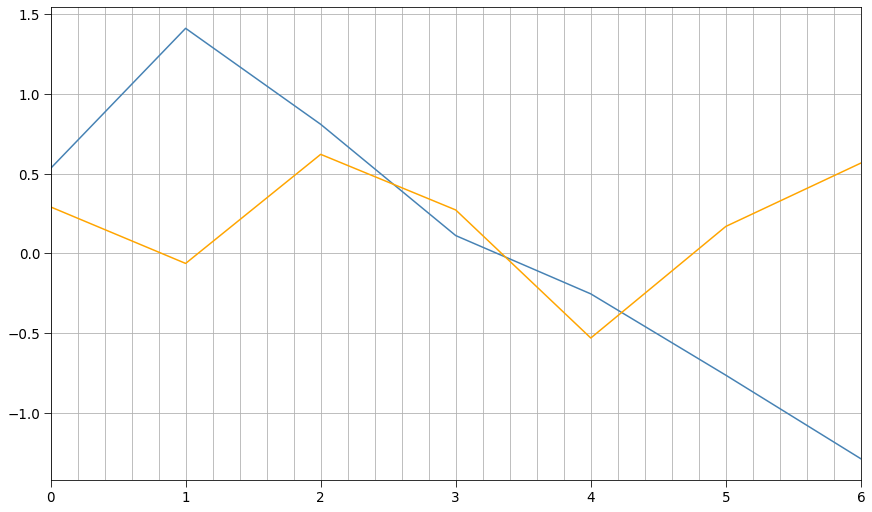

<IPython.core.display.Javascript object>

In [216]:
class ConvForecaster(nn.Module):
    def __init__(self, exogenous_len=None):
        super().__init__()
        self.base_net = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv1_1",
                        nn.Conv1d(1, 4, 3, padding=0, stride=1, bias=False),
                    ),  ## x: 21 -> 19
                    ("bn1_1", nn.BatchNorm1d(4)),
                    ("sigm1_1", nn.Sigmoid()),
                    ("maxp1", nn.MaxPool1d(2, padding=1, stride=2)),  # x: 19 -> 10
                    (
                        "conv2_1",
                        nn.Conv1d(4, 16, 3, padding=0, stride=1, bias=False),
                    ),  # x: 10 -> 8
                    ("bn2_1", nn.BatchNorm1d(16)),
                    ("sigm2_1", nn.Sigmoid()),
                    ("maxp2", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 8 -> 4
                    ("flatten1", nn.Flatten()),
                    ("fc1", nn.Linear(4 * 16, 7, bias=False)),
                    ("bn1", nn.BatchNorm1d(7)),
                    ("sigm1", nn.Sigmoid()),
                    ("fc2", nn.Linear(7, pred_steps, bias=True)),
                ]
            )
        )

        self.exogenous_len = exogenous_len
        if self.exogenous_len is not None:
            self.seasonal_head = nn.Sequential(
                OrderedDict(
                    [
                        ("seasonal_flatten1", nn.Flatten()),
                        (
                            "seasonal_fc1",
                            nn.Linear(pred_steps * (exogenous_len + 1), 5, bias=False),
                        ),
                        ("seasonal_bn1", nn.BatchNorm1d(5)),
                        ("seasonal_sigm1", nn.Sigmoid()),
                        ("seasonal_fc2", nn.Linear(5, pred_steps, bias=True)),
                        #                         (
                        #                             "seasonal_conv",
                        #                             nn.Conv1d(
                        #                                 exogenous_len + 1,
                        #                                 4,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=False,
                        #                             ),
                        #                         ),
                        #                         ("seasonal_bn1", nn.BatchNorm1d(4)),
                        #                         ("seasonal_sigm1", nn.Sigmoid()),
                        #                         (
                        #                             "seasonal_conv2",
                        #                             nn.Conv1d(
                        #                                 4,
                        #                                 1,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=True,
                        #                             ),
                        #                         ),
                    ]
                )
            )

    def forward(self, x, ex=None):
        #         print(x.shape)
        #         print(x)
        x = self.base_net.forward(x)
        if ex is not None:
            #             print(x)
            #             print(x.shape)
            #             print(ex.shape)
            x = x.reshape((x.shape[0], 1, x.shape[1]))
            #             print(x.shape)
            #             print(x)
            #             print(ex)
            x = torch.cat((x, ex), 1)
            #             print(x)
            #                         x = x.reshape((1, x.shape[0], x.shape[1]))
            #             print(x)
            #             print(x.shape)
            x = self.seasonal_head(x)
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        return x

    def set_base_params(self, trainable=True):
        for param in self.base_net.parameters():
            param.requires_grad = True


module = ConvForecaster(exogenous_len=days_of_week).to(device)
module.eval()
# x, y = tw_val_dataset.__getitem__(1)
# x = x.astype(np.float32)
# x = torch.tensor(x).reshape((1, 1, 21)).to(device)
# pred = module(x).detach().numpy().reshape(pred_steps)
# fig = plot_ts(y)
# plot_ts(pred, color="orange", fig=fig)
(x, ex), (y, original_prevs) = tw_seasonal_val_dataset.__getitem__(1)
x = x.astype(np.float32)
x = torch.tensor(x).reshape((1, 1, window_len)).to(device)
ex = ex.astype(np.float32)
ex = torch.tensor(ex).reshape(1, days_of_week, pred_steps).to(device)
pred = module(x, ex).cpu().detach().numpy()
print(y)
print(pred)
pred = pred.reshape(pred_steps)
fig = plot_ts(y[0])
plot_ts(pred, color="orange", fig=fig)
fig

In [76]:
class ConvForecaster(nn.Module):
    def __init__(self, exogenous_len=None):
        super().__init__()
        self.base_net = nn.Sequential(
            OrderedDict(
                [
                    (
                        "conv1_1",
                        nn.Conv1d(1, 4, 3, padding=0, stride=1, bias=False),
                    ),  ## x: 21 -> 19
                    ("bn1_1", nn.BatchNorm1d(4)),
                    ("sigm1_1", nn.Sigmoid()),
                    ("maxp1", nn.MaxPool1d(2, padding=1, stride=2)),  # x: 19 -> 10
                    (
                        "conv2_1",
                        nn.Conv1d(4, 16, 3, padding=0, stride=1, bias=False),
                    ),  # x: 10 -> 8
                    ("bn2_1", nn.BatchNorm1d(16)),
                    ("sigm2_1", nn.Sigmoid()),
                    ("maxp2", nn.MaxPool1d(2, padding=0, stride=2)),  # x: 8 -> 4
                    ("flatten1", nn.Flatten()),
                    ("fc1", nn.Linear(4 * 16, 7, bias=False)),
                    ("bn1", nn.BatchNorm1d(7)),
                    ("sigm1", nn.Sigmoid()),
                    ("fc2", nn.Linear(7, pred_steps, bias=True)),
                ]
            )
        )

        self.exogenous_len = exogenous_len
        if self.exogenous_len is not None:
            self.seasonal_head = nn.Sequential(
                OrderedDict(
                    [
                        ("seasonal_flatten1", nn.Flatten()),
                        (
                            "seasonal_fc1",
                            nn.Linear(pred_steps * (exogenous_len + 1), 5, bias=False),
                        ),
                        ("seasonal_bn1", nn.BatchNorm1d(5)),
                        ("seasonal_sigm1", nn.Sigmoid()),
                        ("seasonal_fc2", nn.Linear(5, pred_steps, bias=True)),
                        #                         (
                        #                             "seasonal_conv",
                        #                             nn.Conv1d(
                        #                                 exogenous_len + 1,
                        #                                 4,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=False,
                        #                             ),
                        #                         ),
                        #                         ("seasonal_bn1", nn.BatchNorm1d(4)),
                        #                         ("seasonal_sigm1", nn.Sigmoid()),
                        #                         (
                        #                             "seasonal_conv2",
                        #                             nn.Conv1d(
                        #                                 4,
                        #                                 1,
                        #                                 1,
                        #                                 padding=0,
                        #                                 stride=1,
                        #                                 bias=True,
                        #                             ),
                        #                         ),
                    ]
                )
            )

    def forward(self, x, ex=None):
        #         print(x.shape)
        #         print(x)
        x = self.base_net.forward(x)
        if ex is not None:
            #             print(x)
            #             print(x.shape)
            #             print(ex.shape)
            x = x.reshape((x.shape[0], 1, x.shape[1]))
            #             print(x.shape)
            #             print(x)
            #             print(ex)
            x = torch.cat((x, ex), 1)
            #             print(x)
            #                         x = x.reshape((1, x.shape[0], x.shape[1]))
            #             print(x)
            #             print(x.shape)
            x = self.seasonal_head(x)
        x = x.reshape((x.shape[0], 1, x.shape[1]))
        return x

    def set_base_params(self, trainable=True):
        for param in self.base_net.parameters():
            param.requires_grad = True

<IPython.core.display.Javascript object>

In [217]:
original_mae = OriginalMetric(trans, "mae")
module = ConvForecaster(exogenous_len=days_of_week).to(device)
val_stopping = val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=50, stats_fun=np.max, min_change=-0.00001
)
# l1_loss = torch.nn.functional.l1_loss
huber_loss = torch.nn.HuberLoss(reduction="sum", delta=0.5)
history = fit(
    module,
    device,
    "Adam",
    huber_loss,
    tw_train_loader,
    tw_val_loader,
    metrics=[original_mae],
    metrics_val_only=True,
    lr=1e-2,
    n_epochs=500,
    stop_cond=val_stopping,
)

Epoch   10:   train_loss: 1.782, val_loss: 3.785, val_mae: 1104, elapsed time: 5.0s elapsed time: 5.0s 
Epoch   17: Validating: [>                                0/241(0%)                                  ] 

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

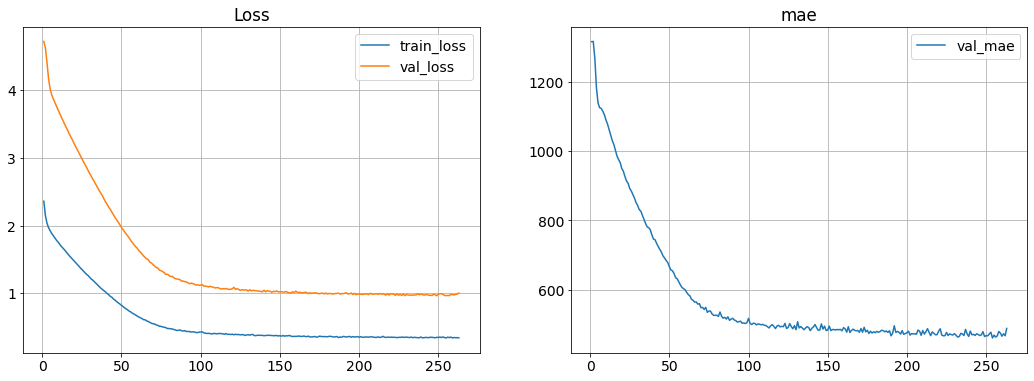

<IPython.core.display.Javascript object>

In [185]:
plot_history(history)

In [368]:
val_stopping = val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=50, stats_fun=np.max, min_change=-0.001
)
module.set_base_params(trainable=False)
history = fit(
    module,
    device,
    "Adam",
    huber_loss,
    tw_seasonal_train_loader,
    tw_seasonal_val_loader,
    [],
    1e-2,
    n_epochs=500,
    reduction="sum",
    stop_cond=val_stopping,
)

Epoch   10:   train_loss: 0.192, val_loss: 0.080, elapsed time: 0.8s]  loss: 0.080, elapsed time: 0.8s 
Epoch   20:   train_loss: 0.191, val_loss: 0.081, elapsed time: 0.8s]  loss: 0.081, elapsed time: 0.8s 
Epoch   30:   train_loss: 0.190, val_loss: 0.081, elapsed time: 0.8s]  loss: 0.081, elapsed time: 0.8s 
Epoch   40:   train_loss: 0.189, val_loss: 0.081, elapsed time: 0.8s]  loss: 0.081, elapsed time: 0.7s 
Epoch   50:   train_loss: 0.187, val_loss: 0.081, elapsed time: 0.7s]  loss: 0.081, elapsed time: 0.7s 
Epoch   51:   train_loss: 0.187, val_loss: 0.081, elapsed time: 0.1s]  loss: 0.081, elapsed time: 0.1s 

<IPython.core.display.Javascript object>

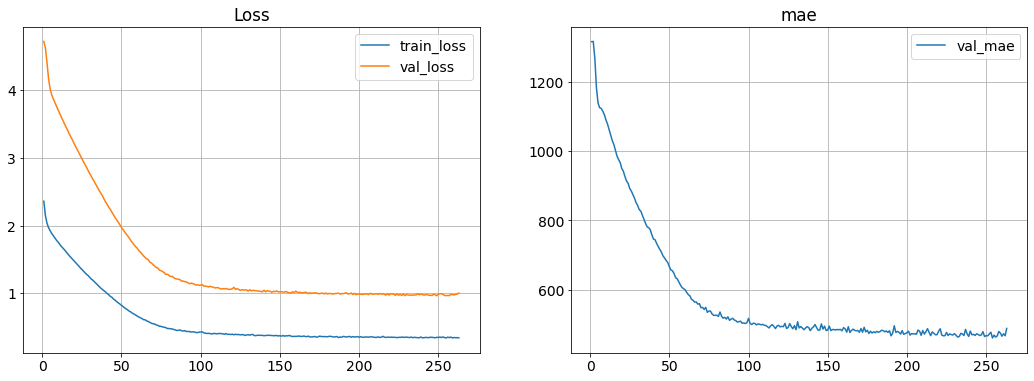

<IPython.core.display.Javascript object>

In [186]:
plot_history(history)

In [383]:
val_stopping = val_loss_stopping = EarlyStopping(
    "Loss", "val_loss", n_epochs=50, stats_fun=np.max, min_change=-0.001
)
module = ConvForecaster(exogenous_len=days_of_week).to(device)
# module.set_base_params(trainable=False)
history = fit(
    module,
    device,
    "Adam",
    huber_loss,
    tw_seasonal_train_loader,
    tw_seasonal_val_loader,
    [],
    1e-2,
    n_epochs=500,
    precision=5,
    stop_cond=val_stopping,
)

Epoch   10:   train_loss: 0.00179, val_loss: 0.00207, elapsed time: 0.8ss: 0.00207, elapsed time: 0.8s 
Epoch   20:   train_loss: 0.00164, val_loss: 0.00195, elapsed time: 0.8ss: 0.00195, elapsed time: 0.8s 
Epoch   30:   train_loss: 0.00154, val_loss: 0.00185, elapsed time: 0.8ss: 0.00185, elapsed time: 0.8s 
Epoch   40:   train_loss: 0.00141, val_loss: 0.00173, elapsed time: 0.8ss: 0.00173, elapsed time: 0.8s 
Epoch   50:   train_loss: 0.00129, val_loss: 0.00160, elapsed time: 0.8ss: 0.00160, elapsed time: 0.8s 
Epoch   51:   train_loss: 0.00127, val_loss: 0.00159, elapsed time: 0.1ss: 0.00159, elapsed time: 0.1s 

<IPython.core.display.Javascript object>

### Time Window Validation

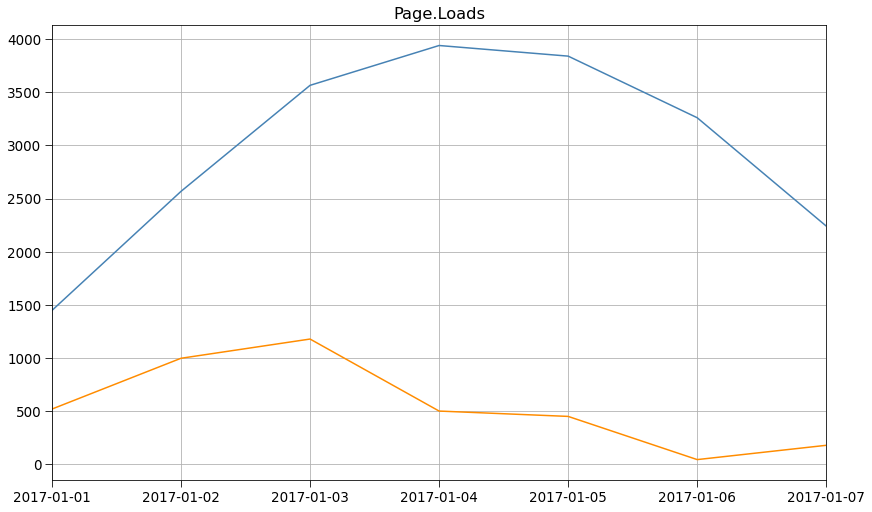

<IPython.core.display.Javascript object>

In [55]:
days_of_week_dct_lst = get_exogenous_seasonal_dct_lst([days_of_week_ts])
intv = tss.Interval(
    trans_ts, datetime(2017, 1, 1), datetime(2017, 1, 1) + timedelta(days=pred_steps)
)
model = TimeWindowForecastingModel(
    module, window_len, device, detrans=trans, seasons_dct_lst=days_of_week_dct_lst
)
pred = model.predict(trans_ts, intv, original_ts=ts, seasonal_ts_seq=[days_of_week_ts])
fig = plot_ts(intv.view(ts))
plot_ts(pred, color="darkorange", fig=fig)

In [377]:
%%time
model = TimeWindowForecastingModel(module, window_len, device, seasons_dct_lst=days_of_week_dct_lst)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    seasonal_ts_seq=[days_of_week_ts],
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

61/61 – MAE: 505.10848, elapsed time: 1.4s (last: 0.0s)      
{'MAE': 505.108478446755}
CPU times: user 2.47 s, sys: 23.6 ms, total: 2.5 s
Wall time: 1.42 s


<IPython.core.display.Javascript object>

In [371]:
%%time
# trained seasonal after normal
module.eval()
model = TimeWindowForecastingModel(module, window_len, device, seasons_dct_lst=days_of_week_dct_lst)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    seasonal_ts_seq=[days_of_week_ts],
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

61/61 – MAE: 517.62954, elapsed time: 1.3s (last: 0.0s)      
{'MAE': 517.6295406600631}
CPU times: user 2.32 s, sys: 20.4 ms, total: 2.34 s
Wall time: 1.28 s


<IPython.core.display.Javascript object>

In [57]:
%%time
model = TimeWindowForecastingModel(module, window_len, device)
model.fit(trans_ts, train_intv)
val_mean_scores, val_all_scores, val_preds = average_scores(
    model,
    trans_ts,
    val_intv,
    scorings=["MAE"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(val_mean_scores)

61/61 – MAE: 454.99199, elapsed time: 1.0s (last: 0.0s)      
{'MAE': 454.99198655166447}
CPU times: user 1.01 s, sys: 19.7 ms, total: 1.03 s
Wall time: 999 ms


<IPython.core.display.Javascript object>

## TMP

In [32]:
import numpy as np

# def dstack(ts_lst):
#     arr = np.dstack(tuple(ts_lst))
#     if arr.shape[0] == 1:
#     arr = arr.reshape(arr.shape[1:])
#     return arr

def to_singlevar_tss(multivar_ts):
    if type(singlevar_ts_seq) is list:
        singlevar_ts_seq = tuple(singlevar_ts_seq)
    arr = np.dstack(singlevar_ts_seq)
    if arr.shape[0] == 1:
        arr = arr.reshape(arr.shape[1:])
    return arr


def to_multivar_ts(singlevar_ts_seq):
    if type(singlevar_ts_seq) is list:
        singlevar_ts_seq = tuple(singlevar_ts_seq)
    arr = np.dstack(singlevar_ts_seq)
    if arr.shape[0] == 1:
        arr = arr.reshape(arr.shape[1:])
    return arr


def split_ts(
    ts_in,
    ts_out,
    n_steps_in,
    n_steps_out,
):
    assert ts_in.shape[0] == ts_out.shape[0]
    n = ts_in.shape[0] - n_steps_in - n_steps_out + 1
    xs = np.empty(shape=(n, n_steps_in) + ts_in.shape[1:])
    ys = np.empty(shape=(n, n_steps_out) + ts_out.shape[1:])

    for i in range(n):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        xs[i,] = ts_in[
            i:end_ix,
        ]
        ys[i,] = ts_out[
            end_ix:out_end_ix,
        ]
    return xs, ys


def train_val_test_split(xs, ys, test, val):
    n = xs.shape[0]
    nv = val
    if isinstance(val, float):
        nv = n * val
    nt = test
    if isinstance(test, float):
        nt = n * test
    train_slice = slice(0, n - nv - nt)
    val_slice = slice(n - nv - nt, n - nt)
    test_slice = slice(n - nt, n)
    return (
        (xs[train_slice], ys[train_slice]),
        (xs[val_slice], ys[val_slice]),
        (xs[test_slice], ys[test_slice]),
    )


def train_test_split(xs, ys, test):
    train_xy, _, test_xy = train_val_test_split(xs, ys, test, 0)
    return (train_xy, test_xy)



<IPython.core.display.Javascript object>